# Plant Disease Classification - Test

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline

(256, 256, 3)


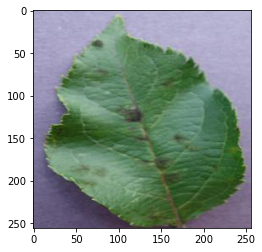

In [2]:
my_data_dir = 'C:\\plant_diseases'
os.listdir(my_data_dir)

test_path = my_data_dir+'\\valid\\'
train_path = my_data_dir+'\\train\\'

os.listdir(test_path)
os.listdir(train_path)
os.listdir(train_path+'\\Apple___Apple_scab')[0]
apple_scab = train_path+'\\Apple___Apple_scab\\' + '00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG'
apple_scab_img = imread(apple_scab)
plt.imshow(apple_scab_img)

image_shape = apple_scab_img.shape
print(image_shape)

In [3]:
print(apple_scab_img.max())
print(apple_scab_img.min())

print(len(os.listdir(train_path+'\\Apple___Apple_scab\\')))
print(len(os.listdir(train_path + '\\Peach___healthy\\')))
print(len(os.listdir(test_path+'\\Apple___Apple_scab\\')))
print(len(os.listdir(test_path + '\\Peach___healthy\\')))

226
0
2016
1728
504
432


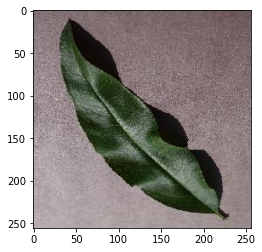

In [4]:
plt.imshow(imread(train_path + '\\Peach___healthy\\' + '017d3d86-12bf-4280-8929-10dcd504ac46___Rutg._HL 3671.JPG'))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.05, # Shift the pic width by a max of 5%
                               height_shift_range=0.05, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.0, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

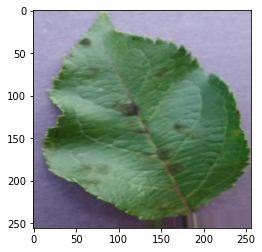

In [6]:
plt.imshow(image_gen.random_transform(apple_scab_img))

In [7]:
image_gen.flow_from_directory(train_path)
image_gen.flow_from_directory(test_path)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.applications.densenet import DenseNet201, decodepredictions

base_model = DenseNet201(include_top=False,
                         input_shape=(256,256,3),
                         weights='imagenet',
                         pooling="avg"
                        )

base_model.trainable = False
image_input = Input(shape=(256, 256, 3))

x = base_model(image_input,training = False)

x = Dense(256,activation = "relu")(x)
x = Dropout(0.2)(x)

x = Dense(128,activation = "relu")(x)
x = Dropout(0.2)(x)

image_output = Dense(38,activation="softmax")(x)

model = Model(image_input,image_output)
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense (Dense)                (None, 256)               491776    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 38)                4902  

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=2)

batch_size = 16

train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical')

test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [11]:
df = pd.DataFrame(train_image_gen.class_indices.items())
df.rename(columns={1:"Index", 0:"Class Name"}, inplace=True)
df.set_index(inplace=True, keys="Index")
df

,Class Name
Index,
0,Apple___Apple_scab
1,Apple___Black_rot
2,Apple___Cedar_apple_rust
3,Apple___healthy
4,Blueberry___healthy
5,Cherry_(including_sour)___Powdery_mildew
6,Cherry_(including_sour)___healthy
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
8,Corn_(maize)___Common_rust_


In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
results = model.fit(train_image_gen,epochs=10,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/10
4394/4394 [==============================] - 1365s 308ms/step - loss: 0.5199 - accuracy: 0.8372 - val_loss: 0.1640 - val_accuracy: 0.9451
Epoch 2/10
4394/4394 [==============================] - 1144s 260ms/step - loss: 0.2421 - accuracy: 0.9200 - val_loss: 0.1805 - val_accuracy: 0.9381
Epoch 3/10
4394/4394 [==============================] - 1138s 259ms/step - loss: 0.2047 - accuracy: 0.9337 - val_loss: 0.1252 - val_accuracy: 0.9573
Epoch 4/10
4394/4394 [==============================] - 1150s 262ms/step - loss: 0.1868 - accuracy: 0.9398 - val_loss: 0.1165 - val_accuracy: 0.9611
Epoch 5/10
4394/4394 [==============================] - 1148s 261ms/step - loss: 0.1714 - accuracy: 0.9446 - val_loss: 0.1198 - val_accuracy: 0.9601
Epoch 6/10
4394/4394 [==============================] - 1126s 256ms/step - loss: 0.1593 - accuracy: 0.9493 - val_loss: 0.0996 - val_accuracy: 0.9669
Epoch 7/10
4394/4394 [==============================] - 1313s 299ms/step - loss: 0.1552 - accuracy: 0.9506

In [14]:
from tensorflow.keras.models import load_model
model.save("pdc2.h5")

<AxesSubplot:>

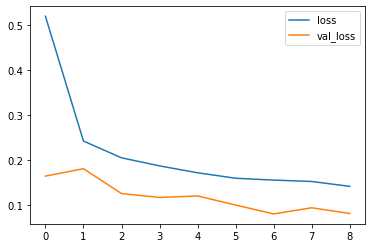

In [15]:
losses = pd.DataFrame(model.history.history)

losses[['loss','val_loss']].plot()

In [16]:
model.evaluate_generator(test_image_gen)

[0.0801190659403801, 0.9730821847915649]

In [17]:
from tensorflow.keras.preprocessing import image

In [18]:
pred_probabilities = model.predict(test_image_gen)

In [19]:
test_image_gen.classes

array([ 0,  0,  0, ..., 37, 37, 37])

In [20]:
predictions = [np.argmax(i) for i in pred_probabilities]

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       504
           1       1.00      0.97      0.98       497
           2       1.00      0.99      0.99       440
           3       0.96      0.99      0.97       502
           4       1.00      1.00      1.00       454
           5       0.99      0.99      0.99       421
           6       1.00      0.99      1.00       456
           7       0.93      0.92      0.92       410
           8       1.00      0.99      0.99       477
           9       0.93      0.94      0.93       477
          10       1.00      1.00      1.00       465
          11       0.98      0.99      0.98       472
          12       0.99      0.97      0.98       480
          13       1.00      1.00      1.00       430
          14       1.00      1.00      1.00       423
          15       1.00      0.99      1.00       503
          16       0.98      0.98      0.98       459
          17       0.95    

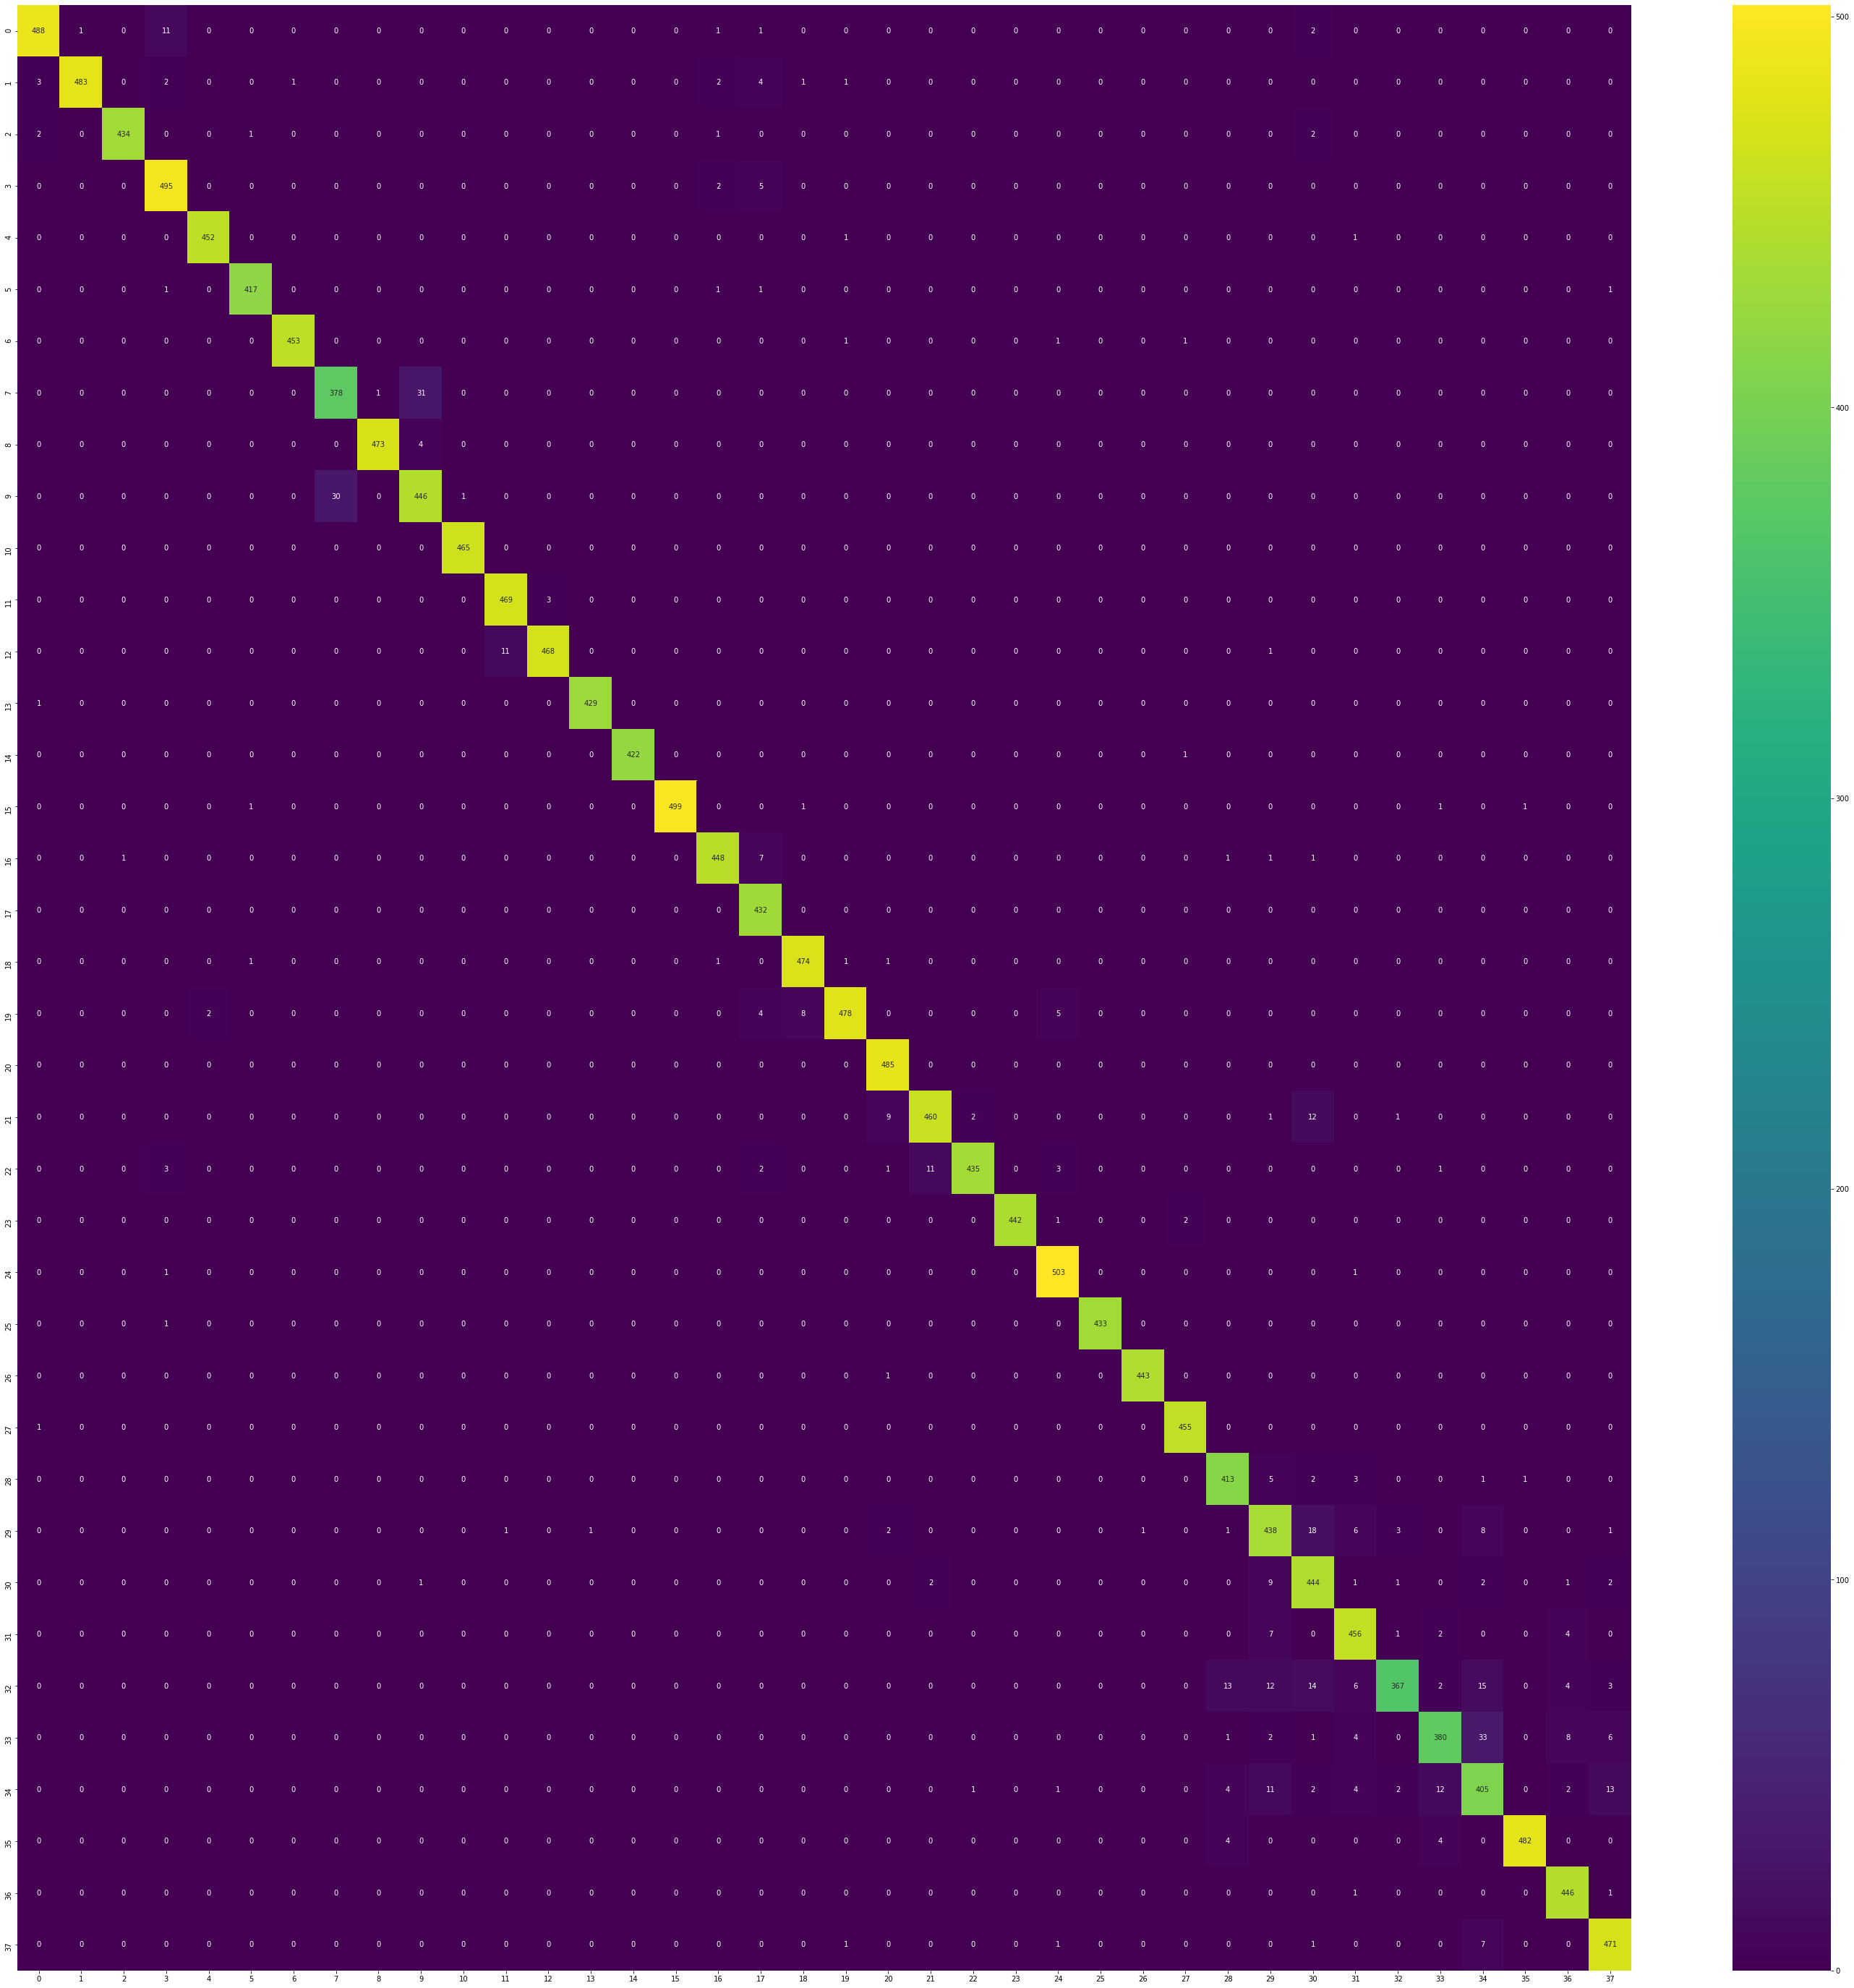

In [21]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_image_gen.classes,predictions))
plt.figure(figsize=(50,50))
sns.heatmap(confusion_matrix(test_image_gen.classes,predictions),annot = True, fmt = "d", cmap = "viridis");

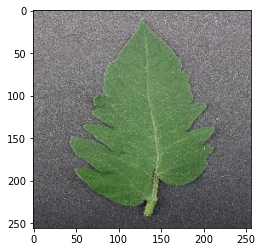

In [95]:
# Prediction of external image
from tensorflow.keras.preprocessing import image

image_to_predict = image.load_img('C:\\plant_diseases\\post_train_testing\\tomato.JPG', target_size=(256,256))
image_to_predict = np.expand_dims(image_to_predict, axis=1)
image_to_predict = image_to_predict.reshape(256, 256, 3)
image_to_predict = image_to_predict / 256
plt.imshow(image_to_predict)

In [96]:
prediction = model.predict(image_to_predict.reshape(1, 256, 256, 3))
print(prediction.shape)
print(prediction)
print(prediction.argmax(axis=1))

(1, 38)
[[1.7634623e-24 4.7348870e-31 3.4428056e-29 1.5743955e-25 1.5811018e-23
  2.3252632e-24 1.1068738e-30 7.2479103e-37 2.5185008e-38 9.9598523e-35
  1.3897568e-29 2.0147917e-30 5.2918702e-38 0.0000000e+00 7.8856624e-34
  1.9721624e-30 1.5582226e-31 9.8371360e-35 1.6042322e-29 1.8857746e-22
  0.0000000e+00 4.1922177e-33 1.8793499e-34 7.3915783e-34 1.0949971e-30
  6.7402366e-25 0.0000000e+00 3.7738254e-33 4.6571530e-19 8.1061650e-22
  1.3093158e-11 5.4683601e-22 1.9091221e-17 1.8588026e-18 7.2430566e-19
  1.9999117e-24 6.0398847e-24 1.0000000e+00]]
[37]
